Mounted at /content/drive


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 7, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 7, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 7, 4)           │           132 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,076 (637.02 KB)

 Trainable params: 163,076 (637.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - loss: 0.2087 - mae: 0.3539 - val_loss: 0.1251 - val_mae: 0.2768
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.1162 - mae: 0.2686 - val_loss: 0.1099 - val_mae: 0.2650
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - loss: 0.1050 - mae: 0.2569 - val_loss: 0.1025 - val_mae: 0.2568
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step - loss: 0.0959 - mae: 0.2469 - val_loss: 0.0950 - val_mae: 0.2517
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0908 - mae: 0.2449 - val_loss: 0.0923 - val_mae: 0.2482
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0882 - mae: 0.2398 - val_loss: 0.0913 - val_mae: 0.2470
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0872 - mae: 0.2401 - val_loss: 0.0894 - val_mae: 0.2449
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0866 - mae: 0.2404 - val_loss: 0.0893 - val_mae: 0.2438
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0857 - ma

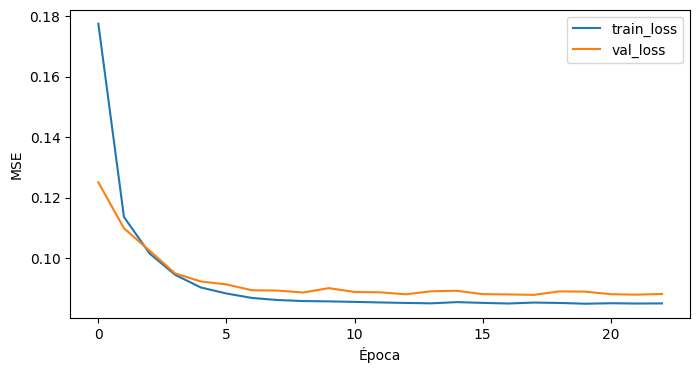

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 529ms/step
total_sales  → RMSE: 3.87, MAE: 3.08
total_sessions → RMSE: 442.67, MAE: 336.96
dow_sin      → RMSE: 0.71, MAE: 0.63
dow_cos      → RMSE: 0.71, MAE: 0.64


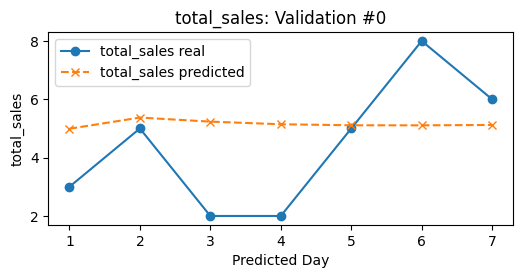

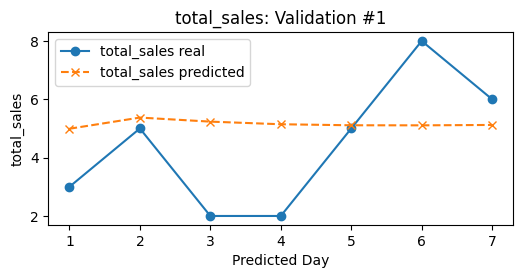

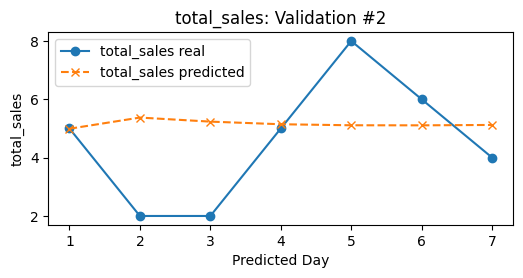

In [2]:
# ─── 1) Drive and Libraries ──────────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, LSTM, Dropout, RepeatVector, TimeDistributed, Dense
)
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


# ─── 2) Initial loading and preprocessing ──────────────────────────────────────────────────
ruta = '/content/drive/MyDrive/ecommerce_dashboard/data/combined_final.csv'
df = pd.read_csv(ruta)
df['day'] = pd.to_datetime(df['day'])
df = df.set_index('day').sort_index()

# Fill in daily gaps
idx = pd.date_range(df.index.min(), df.index.max(), freq='D')
df = df.reindex(idx)
df[['total_sales','total_sessions']] = df[['total_sales','total_sessions']].ffill()

# Exclude ignores and drop excess columns
df = df[df['ignore'] == False]
df = df.drop(columns=['inventory','ignore'])


# ─── 3) Add calendar variables ──────────────────────────────────────────────
df['dow']     = df.index.dayofweek
df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)

features = ['total_sales','total_sessions','dow_sin','dow_cos']
window_size = 30
horizon     = 7


# ─── 4) Function to create windows ────────────────────────────────────────────────────
def create_windows(df, features, window_size, horizon):
    arr = df[features].values
    X, y = [], []
    n = len(arr) - window_size - horizon + 1
    for i in range(n):
        X.append(arr[i : i + window_size])
        y.append(arr[i + window_size : i + window_size + horizon])
    return np.array(X), np.array(y)


# ─── 5) Augmentation (Magnitude Warping) ──────────────────────────────────────
def augment_windows(X, y, sigma=0.1):
    def warp(series):
        T = series.shape[0]
        xs = np.linspace(0, T - 1, 4)
        ys = np.random.normal(1.0, sigma, size=4)
        return series * CubicSpline(xs, ys)(np.arange(T))
    X_aug, y_aug = [], []
    for xi, yi in zip(X, y):
        X_aug.append(xi);    y_aug.append(yi)
        warped = np.stack([warp(xi[:, j]) for j in range(xi.shape[1])], axis=1)
        X_aug.append(warped); y_aug.append(yi)
    return np.array(X_aug), np.array(y_aug)


# ─── 6) Generate data and augment ──────────────────────────────────────────────────────
X0, y0 = create_windows(df, features, window_size, horizon)
X1, y1 = augment_windows(X0, y0, sigma=0.1)


# ─── 7) Scale the data ─────────────────────────────────────────────────────────────────────
n_s, T, n_f = X1.shape
scaler_X = MinMaxScaler().fit(X1.reshape(-1, n_f))
Xs = scaler_X.transform(X1.reshape(-1, n_f)).reshape(n_s, T, n_f)

scaler_y = MinMaxScaler().fit(y1.reshape(-1, n_f))
Ys = scaler_y.transform(y1.reshape(-1, n_f)).reshape(n_s, horizon, n_f)


# ─── 8) Separate Train / Val ───────────────────────────────────────────────────
cut = int(n_s * 0.8)
X_train, X_val = Xs[:cut], Xs[cut:]
y_train, y_val = Ys[:cut], Ys[cut:]


# ─── 9) Define the seq2seq model “With calendar” ───────────────────────────────────
model = Sequential([
    Input(shape=(window_size, n_f)),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.1),
    RepeatVector(horizon),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=True),
    TimeDistributed(Dense(n_f))
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


# ─── 10) Train (up to 100 epochs, patience=5) ────────────────────────
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es]
)


# ─── 11) Learning Curve ────────────────────────────────────────────────────────────
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],  label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('Epochs'); plt.ylabel('MSE')
plt.legend(); plt.show()


# ─── 12) Evaluate in real units ─────────────────────────────────────────────────
# Predict
y_pred = model.predict(X_val)

# Descale
n_val = y_val.shape[0]
y_pred_flat = y_pred.reshape(-1, n_f)
y_val_flat  = y_val.reshape(-1, n_f)

y_pred_real = scaler_y.inverse_transform(y_pred_flat).reshape(n_val, horizon, n_f)
y_val_real  = scaler_y.inverse_transform(y_val_flat).reshape(n_val, horizon, n_f)

# Final Metrics
for idx, name in enumerate(['total_sales','total_sessions','dow_sin','dow_cos']):
    rmse = np.sqrt(mean_squared_error(y_val_real[:,:,idx].ravel(), y_pred_real[:,:,idx].ravel()))
    mae  = mean_absolute_error(y_val_real[:,:,idx].ravel(), y_pred_real[:,:,idx].ravel())
    print(f"{name:12s} → RMSE: {rmse:.2f}, MAE: {mae:.2f}")


# ─── 13) Plot different results examples ───────────────────────────────────────
def plot_feature(i, feat_idx, feat_name):
    days = np.arange(1, horizon+1)
    plt.figure(figsize=(6,2.5))
    plt.plot(days, y_val_real[i,:,feat_idx], 'o-', label=f'{feat_name} real')
    plt.plot(days, y_pred_real[i,:,feat_idx], 'x--', label=f'{feat_name} predicted')
    plt.title(f"{feat_name}: Validation #{i}")
    plt.xlabel("Predicted Day")
    plt.ylabel(feat_name)
    plt.legend()
    plt.show()

# Show 3 sales examples
for i in range(3):
    plot_feature(i, 0, 'total_sales')